In [ ]:
# Author: Jaehun Kim
# Email: rlawogns1204@unist.ac.kr
# Affiliation: UNIST BME BCILAB
# Date: 2023-06-12
#
# This code implements a tactile information processing model using a spiking
# neural network (SNN). It simulates the processing of tactile information from
# mechanoreceptors in the skin through primary afferent fibers (PA), cuneate nucleus
# neurons (PN and IN), and ultimately, somatosensory cortex neurons. The model
# incorporates lateral inhibition and various receptive field properties to
# represent a realistic processing of touch stimuli.

# with DIGIT-sensor
# pip install torch==1.8.1+cu101 torchvision==0.9.1+cu101 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io
import time
import numpy as np
from PIL import Image
import io
import datetime
import cv2
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

from Function.snn_IZHIlayers import *
from Function.snn_plot import *
from Function.snn_simulation import *
from Function.snn_stimulation import *
from Function.snn_receptive_field_weights import *

from line_profiler import LineProfiler

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# Check if GPU is available and print the CUDA version
print(f"GPU available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
# Enable GPU support if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the device to 'cpu'
device = 'cpu'
print(f"Using device: {device}")
# Start of the SNN (Spiking Neural Network) code

In [ ]:
# Set sensor dimensions (height and width in millimeters)
sensor_h, sensor_w = 19, 16
# Set pixel dimensions (number of pixels in height and width)
# pixel_h, pixel_w = 320, 240///
pixel_h, pixel_w = 64,48
# Set image frames per second (FPS) of tactile sensor
image_FPS = 60

In [ ]:
R = ReceptiveFieldWeights(pixel_h, pixel_w, device,type_output = 'single')

In [ ]:
num_stim = 1000

# Generate the stimuli and stack them up
r = 1
F = 100/r

stimulation1 = generate_stimuli_dot(num_stim, x0 = 8, y0 = 2, F=F, r=r, plot_stimuli=True, device = device)
stimulation2 = generate_stimuli_dot(num_stim, x0 = 8, y0 = 14,  F=F, r=r, plot_stimuli=True, device = device)

stimulation = (stimulation1 + stimulation2)/2

plt.imshow(stimulation[:, :, 500].cpu(), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()


plt.rcParams['font.size'] = 20
fig_size = (10, 2)
line_lengths = 0.6

S = SNN(R, device = device)
S.feedforward(stimulation1)

mean_firing_rates = plot_SNN(S)
plot_spike_times(S.cn_spike_times[1], size=fig_size, colors='k', line_lengths=line_lengths)

S = SNN(R, device = device)
S.feedforward(stimulation)

mean_firing_rates = plot_SNN(S)
plot_spike_times(S.cn_spike_times[1], size=fig_size, colors='k', line_lengths=line_lengths)

In [ ]:
def calculate_multi_neuron_spike_distance(spike_train1, spike_train2):
    assert spike_train1.shape == spike_train2.shape, "Spike trains must have the same shape"

    num_neurons = spike_train1.shape[0]
    total_distance = 0

    for i in range(num_neurons):
        total_distance += torch.norm(spike_train1[i] - spike_train2[i])

    return total_distance / num_neurons

In [ ]:
def fct_spikeDistance(f, g):
    """
    Calculate the spike distance between two spikes trains.
    f : spike time of 1st spikes train, list.
    g : spike time of 2nd spikes train, list.
    e.g) 
    f = [-1, 8, 9]
    g = [0,8 ,10]
    Returns d : spike distance between f and g
    """
    f = torch.nonzero(f)
    g = torch.nonzero(g)

    f = f.flatten()
    g = g.flatten()
    p = np.unique(np.sort(np.concatenate((f, g))))
    
    idx_f = np.where(np.isin(p, f))[0]
    idx_g = np.where(np.isin(p, g))[0]

    val = np.zeros((2, p.shape[0]))
    if len(f) != 0:
        val[0, idx_f] = 1 / len(f)
    else:
        val[0, idx_f] = np.inf  # or any value that fits your needs

    if len(g) != 0:
        val[1, idx_g] = 1 / len(g)
    else:
        val[1, idx_g] = np.inf  # or any value that fits your needs

     # Check if the index arrays are empty before getting min value
    f_larger_indices = np.where(val[0,:] > val[1,:])
    g_larger_indices = np.where(val[0,:] < val[1,:])
    min_f_large = np.min(f_larger_indices) if f_larger_indices[0].size else None
    min_g_large = np.min(g_larger_indices) if g_larger_indices[0].size else None

    d = 0
    
    while min_f_large is not None and min_g_large is not None:
        min_quantity = np.min([val[0, min_f_large] - val[1, min_f_large], val[1, min_g_large] - val[0, min_g_large]])
        
        d += abs(p[min_f_large] - p[min_g_large]) * min_quantity
        
        val[0,min_f_large] -= min_quantity
        val[0,min_g_large] += min_quantity
        
        f_larger_indices = np.where(val[0,:] > val[1,:])
        g_larger_indices = np.where(val[0,:] < val[1,:])
        min_f_large = np.min(f_larger_indices) if f_larger_indices[0].size else None
        min_g_large = np.min(g_larger_indices) if g_larger_indices[0].size else None
        
    return d


In [ ]:
num_stim = 1000
x0 = 8
# Generate the stimuli and stack them up
r = 1
F = 50/r

plt.rcParams['font.size'] = 20
fig_size = (10, 2)
line_lengths = 0.6

# List to store distances
distances = []
spike_distances = []

for delta in np.linspace(0.1, 8, 2):  # adjust this range as needed
    y0_1 = 10 - delta / 2
    y0_2 = 10 + delta / 2

    stimulation1 = generate_stimuli_dot(num_stim, x0 = x0, y0 = y0_1, F=F, r=r, plot_stimuli=False, device = device)
    stimulation2 = generate_stimuli_dot(num_stim, x0 = x0, y0 = y0_2, F=F, r=r, plot_stimuli=False, device = device)
    
    stimulation = (stimulation1 + stimulation2)

    plt.imshow(stimulation[:, :, 500].cpu(), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

    S = SNN(R, device = device)
    S.feedforward(stimulation1)

    mean_firing_rates = plot_SNN(S)
    # plot_spike_times(S.cn_spike_times[1], size=fig_size, colors='k', line_lengths=line_lengths)
    tmp_spike_times1 = S.cn_spike_times[1]


    S = SNN(R, device = device)
    S.feedforward(stimulation)

    mean_firing_rates = plot_SNN(S,layers = ['sa','ra','cn'],plot_figure = True)
    # plot_spike_times(S.cn_spike_times[1], size=fig_size, colors='k', line_lengths=line_lengths)
    tmp_spike_times2 = S.cn_spike_times[1]

    # Calculate the spike distance

    for i in range(len(tmp_spike_times2)):
        d = fct_spikeDistance(tmp_spike_times1[i],tmp_spike_times2[i])
        print(i, d)

    # spike_distance = calculate_multi_neuron_spike_distance(tmp_spike_times1, tmp_spike_times2)

    # Add to lists
    distances.append(delta)
    # spike_distances.append(spike_distance)
    print("The distance between the two points is:", delta)

# plt.figure(figsize=(10,5))
# plt.plot(distances, spike_distances, marker='o')
# plt.xlabel('Distance between stimuli')
# plt.ylabel('Spike distance')
# plt.title('Spike distance as a function of stimulus distance')
# plt.grid(True)
# plt.show()

In [ ]:
# num_stim, x0, F, r, device is defined above

# List to store distances
distances = []
spike_distances = []

for delta in np.linspace(0.1, 8.1, 80):  # adjust this range as needed
    y0_1 = 10 - delta / 2
    y0_2 = 10 + delta / 2

    stimulation1 = generate_stimuli_dot(num_stim, x0 = x0, y0 = y0_1, F=F, r=r, plot_stimuli=False, device = device)
    stimulation2 = generate_stimuli_dot(num_stim, x0 = x0, y0 = y0_2, F=F, r=r, plot_stimuli=False, device = device)
    
    stimulation = (stimulation1 + stimulation2)/2

    # plt.imshow(stimulation[:, :, 500].cpu(), cmap='gray')
    # plt.xticks([])
    # plt.yticks([])
    # plt.show()

    S = SNN(R, device = device)
    S.feedforward(stimulation1)

    mean_firing_rates = plot_SNN(S,plot_figure=False)
    tmp_spike_times1 = S.cn_spike_times[1]

    S = SNN(R, device = device)
    S.feedforward(stimulation)

    mean_firing_rates = plot_SNN(S,plot_figure=False)
    tmp_spike_times2 = S.cn_spike_times[1]

    # Calculate the spike distance
    total_spike_distance = 0
    num_neurons = len(tmp_spike_times2)
    for i in range(num_neurons):
        d = fct_spikeDistance(tmp_spike_times1[i],tmp_spike_times2[i])
        total_spike_distance += d

    avg_spike_distance = total_spike_distance / num_neurons

    # Add to lists
    distances.append(delta)
    spike_distances.append(avg_spike_distance)
    print("The distance between the two points is:", delta)
    print("average distance between the two points is:", avg_spike_distance)

plt.figure(figsize=(10,5))
plt.plot(distances, spike_distances, marker='o')
plt.xlabel('Distance between stimuli')
plt.ylabel('Average Spike distance')
plt.title('Average Spike distance as a function of stimulus distance')
plt.grid(True)
plt.show()

The distance between the two points is: 0.1
average distance between the two points is: 5.58934511341774
The distance between the two points is: 0.20126582278481014
average distance between the two points is: 5.686027216842525
The distance between the two points is: 0.30253164556962026
average distance between the two points is: 7.031086039938644
The distance between the two points is: 0.4037974683544304
average distance between the two points is: 5.802310132858777
The distance between the two points is: 0.5050632911392405
average distance between the two points is: 7.81577594512624
The distance between the two points is: 0.6063291139240506
average distance between the two points is: 9.163484490825764
The distance between the two points is: 0.7075949367088608
average distance between the two points is: 9.591404065768197
The distance between the two points is: 0.8088607594936709
average distance between the two points is: 9.010929680528266
The distance between the two points is: 0.91012

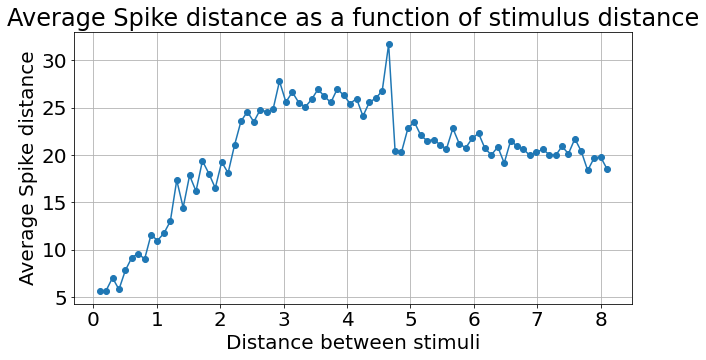

In [123]:
# num_stim, x0, F, r, device is defined above
x0 = 3
# List to store distances
distances = []
spike_distances = []

for delta in np.linspace(0.1, 8.1, 80):  # adjust this range as needed
    y0_1 = 10 
    y0_2 = 10 - delta

    stimulation1 = generate_stimuli_dot(num_stim, x0 = x0, y0 = y0_1, F=F, r=r, plot_stimuli=False, device = device)
    stimulation2 = generate_stimuli_dot(num_stim, x0 = x0, y0 = y0_2, F=F, r=r, plot_stimuli=False, device = device)
    
    stimulation = (stimulation1 + stimulation2)/2

    # plt.imshow(stimulation[:, :, 500].cpu(), cmap='gray')
    # plt.xticks([])
    # plt.yticks([])
    # plt.show()

    S = SNN(R, device = device)
    S.feedforward(stimulation1)

    mean_firing_rates = plot_SNN(S,plot_figure=False)
    tmp_spike_times1 = S.cn_spike_times[1]

    S = SNN(R, device = device)
    S.feedforward(stimulation)

    mean_firing_rates = plot_SNN(S,plot_figure=False)
    tmp_spike_times2 = S.cn_spike_times[1]

    # Calculate the spike distance
    total_spike_distance = 0
    num_neurons = len(tmp_spike_times2)
    for i in range(num_neurons):
        d = fct_spikeDistance(tmp_spike_times1[i],tmp_spike_times2[i])
        total_spike_distance += d

    avg_spike_distance = total_spike_distance / num_neurons

    # Add to lists
    distances.append(delta)
    spike_distances.append(avg_spike_distance)
    print("The distance between the two points is:", delta)
    print("average distance between the two points is:", avg_spike_distance)

plt.figure(figsize=(10,5))
plt.plot(distances, spike_distances, marker='o')
plt.xlabel('Distance between stimuli')
plt.ylabel('Average Spike distance')
plt.title('Average Spike distance as a function of stimulus distance')
plt.grid(True)
plt.show()

The distance between the two points is: 0.1
average distance between the two points is: tensor(0.0179)
The distance between the two points is: 0.20126582278481014
average distance between the two points is: tensor(0.0189)
The distance between the two points is: 0.30253164556962026
average distance between the two points is: tensor(0.0195)
The distance between the two points is: 0.4037974683544304
average distance between the two points is: tensor(0.0192)
The distance between the two points is: 0.5050632911392405
average distance between the two points is: tensor(0.0213)
The distance between the two points is: 0.6063291139240506
average distance between the two points is: tensor(0.0212)
The distance between the two points is: 0.7075949367088608
average distance between the two points is: tensor(0.0207)
The distance between the two points is: 0.8088607594936709
average distance between the two points is: tensor(0.0215)
The distance between the two points is: 0.910126582278481
average dis

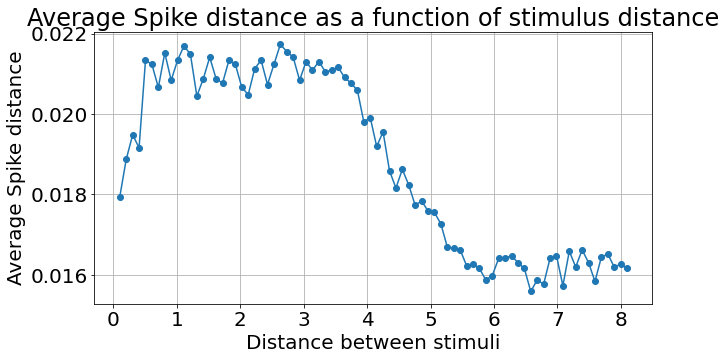

In [124]:
# num_stim, x0, F, r, device is defined above
x0 = 3
# List to store distances
distances = []
spike_distances = []

for delta in np.linspace(0.1, 8.1, 80):  # adjust this range as needed
    y0_1 = 10 
    y0_2 = 10 - delta

    stimulation1 = generate_stimuli_dot(num_stim, x0 = x0, y0 = y0_1, F=F, r=r, plot_stimuli=False, device = device)
    stimulation2 = generate_stimuli_dot(num_stim, x0 = x0, y0 = y0_2, F=F, r=r, plot_stimuli=False, device = device)
    
    stimulation = (stimulation1 + stimulation2)/2

    # plt.imshow(stimulation[:, :, 500].cpu(), cmap='gray')
    # plt.xticks([])
    # plt.yticks([])
    # plt.show()

    S = SNN(R, device = device)
    S.feedforward(stimulation1)

    mean_firing_rates = plot_SNN(S,plot_figure=False)
    tmp_spike_times1 = S.cn_spike_times[1]

    S = SNN(R, device = device)
    S.feedforward(stimulation)

    mean_firing_rates = plot_SNN(S,plot_figure=False)
    tmp_spike_times2 = S.cn_spike_times[1]

    # Calculate the spike distance
    total_spike_distance = 0
    num_neurons = len(tmp_spike_times2)
    for i in range(num_neurons):
        d = calculate_multi_neuron_spike_distance(tmp_spike_times1[i],tmp_spike_times2[i])
        total_spike_distance += d

    avg_spike_distance = total_spike_distance / num_neurons

    # Add to lists
    distances.append(delta)
    spike_distances.append(avg_spike_distance)
    print("The distance between the two points is:", delta)
    print("average distance between the two points is:", avg_spike_distance)

plt.figure(figsize=(10,5))
plt.plot(distances, spike_distances, marker='o')
plt.xlabel('Distance between stimuli')
plt.ylabel('Average Spike distance')
plt.title('Average Spike distance as a function of stimulus distance')
plt.grid(True)
plt.show()